In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os

# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk("/content/drive/MyDrive/data"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '/content/drive/MyDrive/data'.
There are 0 directories and 1636 images in '/content/drive/MyDrive/data/CT_NonCOVID'.
There are 0 directories and 1601 images in '/content/drive/MyDrive/data/CT_COVID'.


In [5]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
import pathlib
import numpy as np
data_dir = pathlib.Path("/content/drive/MyDrive/data") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['CT_COVID' 'CT_NonCOVID']


In [6]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
def view_random_image(target_dir, target_class):
    # Setup target directory (we'llview images from here)
    target_folder = target_dir + target_class

    # Get a random image path
    random_image = random.sample(os.listdir(target_folder), 1)

    # Read in the image and plot it using matplotlib
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")

    print(f"Image shape: {img.shape}")  # Show the shape of the image

    return img

Image shape: (267, 336, 4)


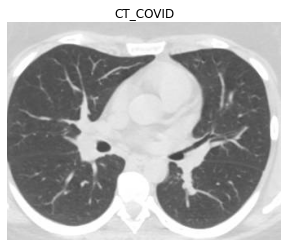

In [8]:
# View a random image from the training dataset
img = view_random_image(target_dir="/content/drive/MyDrive/data/",
                        target_class="CT_COVID")

## An end-to-end example

In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 0 & 1, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)

# Setup paths to our data directories
train_dir = "/content/drive/MyDrive/data"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=16,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)
# Build a CNN model (same as the Tiny VGG on the CNN explainer website)
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10,
                         kernel_size=3,
                         activation="relu",
                         input_shape=(224, 224, 3)),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2,
                            padding="valid"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile our CNN
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

Found 3237 images belonging to 2 classes.


In [17]:
# Get a model summary
model_1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 220, 220, 10)      910       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 108, 108, 10)      910       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 54, 54, 10)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 52, 52, 10)        910       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 26, 26, 10)       

In [19]:
# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=5)

Epoch 1/5
203/203 [==============================] - 19s 95ms/step - loss: 0.3030 - accuracy: 0.8755
Epoch 2/5
203/203 [==============================] - 19s 94ms/step - loss: 0.2549 - accuracy: 0.9024
Epoch 3/5
203/203 [==============================] - 20s 98ms/step - loss: 0.2261 - accuracy: 0.9101
Epoch 4/5
203/203 [==============================] - 20s 98ms/step - loss: 0.2052 - accuracy: 0.9184
Epoch 5/5
203/203 [==============================] - 19s 93ms/step - loss: 0.1743 - accuracy: 0.9311


In [20]:
model_1.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


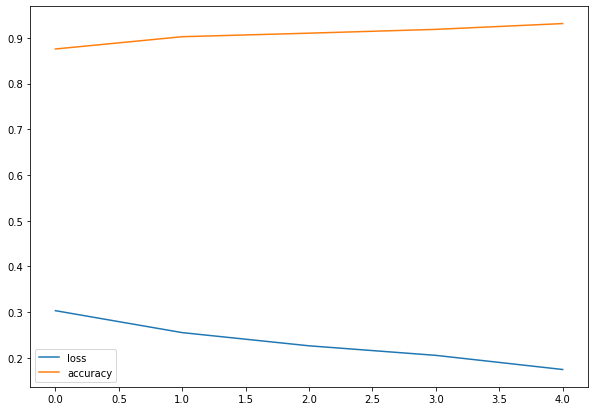

In [21]:
# Let's plot the training curves
import pandas as pd
pd.DataFrame(history_1.history).plot(figsize=(10, 7));

## Data Augmentation

In [22]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=0.2, # how much do you want to rotate an image?
                                             shear_range=0.2, # how much do you want to shear an image?
                                             zoom_range=0.2, # zoom in randomly on an image
                                             width_shift_range=0.2, # move your iamge around on the x-axis
                                             height_shift_range=0.2, # move your image around on the y-axis
                                             horizontal_flip=True) # do you want to flip and image? 

# Create ImageDataGenerator without data augmentation
train_datagen = ImageDataGenerator(rescale=1/255.)

In [26]:
# Import data and augment it from training directory
print("Augmented training data:")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode="binary",
                                                                   shuffle=False) # for demonstration purposes only

# Create non-augmented train data batches
print("Non-augmented training data:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode="binary",
                                               shuffle=False)

Augmented training data:
Found 3237 images belonging to 2 classes.
Non-augmented training data:
Found 3237 images belonging to 2 classes.


In [27]:
# Get sample data batches
images, labels = train_data.next()
augmented_images, augmented_labels = train_data_augmented.next() # note: labels aren't augmented... only data (images)

showing image number: 16


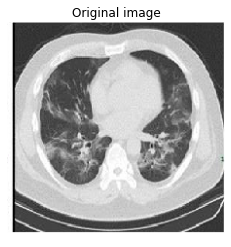

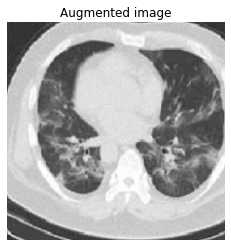

In [28]:
# Show original image and augmented image
import random
random_number = random.randint(0, 32) # our batch sizes are 32...
print(f"showing image number: {random_number}")
plt.imshow(images[random_number])
plt.title(f"Original image")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image")
plt.axis(False);

In [31]:
# Make the creating of our model a little easier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

In [32]:
# Create the model (same as model_5)
model_2 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(pool_size=2), # reduce number of features by half
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_2.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
history_2 = model_2.fit(train_data_augmented, # changed to augmented training data
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented))

Epoch 1/5
102/102 [==============================] - 48s 466ms/step - loss: 0.7074 - accuracy: 0.4615
Epoch 2/5
102/102 [==============================] - 45s 445ms/step - loss: 0.7010 - accuracy: 0.5264
Epoch 3/5
102/102 [==============================] - 47s 456ms/step - loss: 0.6930 - accuracy: 0.4591
Epoch 4/5
102/102 [==============================] - 47s 458ms/step - loss: 0.6906 - accuracy: 0.4881
Epoch 5/5
102/102 [==============================] - 46s 451ms/step - loss: 0.6896 - accuracy: 0.4739


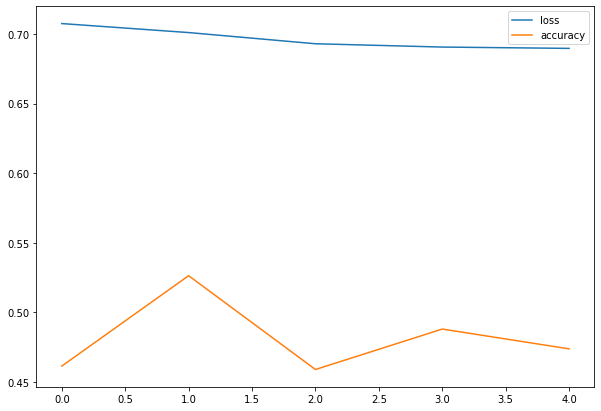

In [34]:
# Let's plot the training curves
import pandas as pd
pd.DataFrame(history_2.history).plot(figsize=(10, 7));

🤔 **Question: Why didn't our model get very good results on the training set to begin with?**

It's because when we created train_data_augmented we turned off data shuffling using shuffle=False which means our model only sees a batch of a single kind of images at a time.

For example, the pizza class gets loaded in first because it's the first class. Thus it's performance is measured on only a single class rather than both classes. The validation data performance improves steadily because it contains shuffled data.

Since we only set shuffle=False for demonstration purposes (so we could plot the same augmented and non-augmented image), we can fix this by setting shuffle=True on future data generators.

In [29]:
# Import data and augment it from directories
train_data_augmented_shuffled = train_datagen_augmented.flow_from_directory(train_dir,
                                                                            target_size=(224, 224),
                                                                            batch_size=32,
                                                                            class_mode='binary',
                                                                            shuffle=True) # Shuffle data (default)

Found 3237 images belonging to 2 classes.


In [35]:
model_3 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_3.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
history_3 = model_3.fit(train_data_augmented_shuffled, # now the augmented data is shuffled
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented_shuffled))

Epoch 1/5
102/102 [==============================] - 46s 451ms/step - loss: 0.6889 - accuracy: 0.5382
Epoch 2/5
102/102 [==============================] - 46s 449ms/step - loss: 0.6742 - accuracy: 0.5860
Epoch 3/5
102/102 [==============================] - 47s 462ms/step - loss: 0.6449 - accuracy: 0.6265
Epoch 4/5
102/102 [==============================] - 47s 457ms/step - loss: 0.6133 - accuracy: 0.6800
Epoch 5/5
102/102 [==============================] - 45s 443ms/step - loss: 0.5947 - accuracy: 0.7010


In [37]:
model_3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 222, 222, 10)      280       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 111, 111, 10)      0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 109, 109, 10)      910       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 54, 54, 10)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 52, 52, 10)        910       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 26, 26, 10)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 6760)             

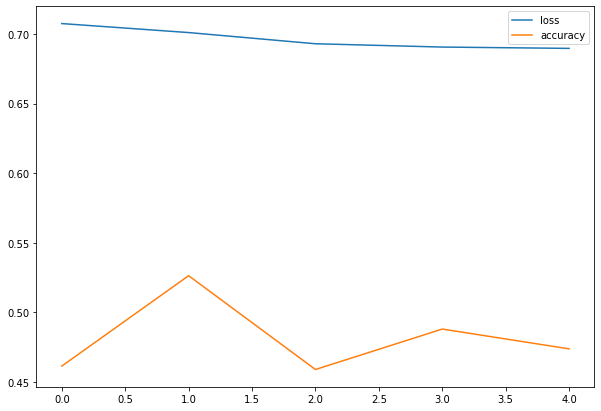

In [36]:
# Let's plot the training curves
import pandas as pd
pd.DataFrame(history_3.history).plot(figsize=(10, 7));

## First Model (Tiny VGG)

In [38]:
model_4 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10,
                         kernel_size=3,
                         activation="relu",
                         input_shape=(224, 224, 3)),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2,
                            padding="valid"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid")
])
model_4.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 220, 220, 10)      910       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 108, 108, 10)      910       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 54, 54, 10)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 52, 52, 10)        910       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 26, 26, 10)       

In [41]:
# Compile our CNN
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_4 = model_4.fit(train_data_augmented_shuffled,
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented_shuffled))

Epoch 1/5
102/102 [==============================] - 48s 466ms/step - loss: 0.5483 - accuracy: 0.7454
Epoch 2/5
102/102 [==============================] - 47s 460ms/step - loss: 0.5274 - accuracy: 0.7553
Epoch 3/5
102/102 [==============================] - 48s 472ms/step - loss: 0.5174 - accuracy: 0.7584
Epoch 4/5
102/102 [==============================] - 48s 470ms/step - loss: 0.4920 - accuracy: 0.7686
Epoch 5/5
102/102 [==============================] - 47s 457ms/step - loss: 0.4959 - accuracy: 0.7739


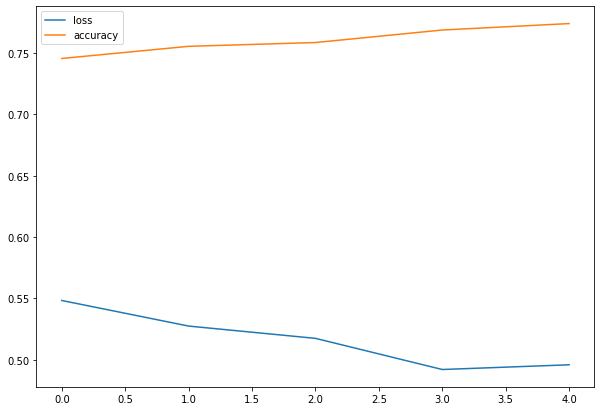

In [42]:
# Let's plot the training curves
import pandas as pd
pd.DataFrame(history_4.history).plot(figsize=(10, 7));

## Prediction

In [43]:
def load_and_prep_image(filename, img_shape=224):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into (224,224,3).
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [44]:
# Load in and preprocess our custom image
covid = load_and_prep_image("covid.png")
covid

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[0.9971786 , 0.9971786 , 0.9971786 ],
        [0.98840106, 0.98840106, 0.98840106],
        [1.        , 1.        , 1.        ],
        ...,
        [0.99059546, 0.99059546, 0.99059546],
        [0.9961337 , 0.9961337 , 0.9961337 ],
        [0.9904387 , 0.9904387 , 0.9904387 ]],

       [[0.995443  , 0.995443  , 0.995443  ],
        [0.9812656 , 0.9812656 , 0.9812656 ],
        [1.        , 1.        , 1.        ],
        ...,
        [0.99290013, 0.99290013, 0.99290013],
        [0.9755408 , 0.9755408 , 0.9755408 ],
        [0.9930861 , 0.9930861 , 0.9930861 ]],

       ...,

       [[0.9609861 , 0.9609861 , 0.9609861 ],
        [0.97

In [45]:
# Add an extra axis
print(f"Shape before new dimension: {covid.shape}")
covid = tf.expand_dims(covid, axis=0) # add an extra dimension at axis 0
#steak = steak[tf.newaxis, ...] # alternative to the above, '...' is short for 'every other dimension'
print(f"Shape after new dimension: {covid.shape}")
covid

Shape before new dimension: (224, 224, 3)
Shape after new dimension: (1, 224, 224, 3)


<tf.Tensor: shape=(1, 224, 224, 3), dtype=float32, numpy=
array([[[[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        [[0.9971786 , 0.9971786 , 0.9971786 ],
         [0.98840106, 0.98840106, 0.98840106],
         [1.        , 1.        , 1.        ],
         ...,
         [0.99059546, 0.99059546, 0.99059546],
         [0.9961337 , 0.9961337 , 0.9961337 ],
         [0.9904387 , 0.9904387 , 0.9904387 ]],

        [[0.995443  , 0.995443  , 0.995443  ],
         [0.9812656 , 0.9812656 , 0.9812656 ],
         [1.        , 1.        , 1.        ],
         ...,
         [0.99290013, 0.99290013, 0.99290013],
         [0.9755408 , 0.9755408 , 0.9755408 ],
         [0.9930861 , 0.9930861 , 0.9930861 ]],

        ...,

        [[0.9609861 , 0.9609861 , 

In [54]:
# Make a prediction on custom image tensor
pred = model_1.predict(covid)
pred

array([[0.02989037]], dtype=float32)

In [48]:
# Remind ourselves of our class names
class_names

array(['CT_COVID', 'CT_NonCOVID'], dtype='<U11')

In [49]:
# We can index the predicted class by rounding the prediction probability
pred_round = int(tf.round(pred))
if pred_round == 1:
  pred_class = "NonCovid"
else:
  pred_class = "Covid"
pred_class

'Covid'

In [64]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_round = int(tf.round(pred))
  if pred_round == 1:
    pred_class = "NonCovid"
  else:
    pred_class = "Covid"

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

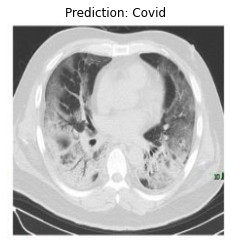

In [65]:
# Test our model on a custom image
pred_and_plot(model_1, "covid.png", class_names)

## Transfer Learning with Tensorflow Part 1: Feature Extraction

In [66]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# EfficientNet0 feature vector
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [74]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url(str): A TensorFlow Hub feature extraction URL.
    num_classes(int): Number of output neurons in the output layer, 
      should be equal to number of target classes, default = 10

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor 
    layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable = False,   # freeze the already learned patterns
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,))  # define the input image shape
  
  # Create our image model
  model = tf.keras.Sequential([
     feature_extractor_layer,    # use the feature extraction layer as the base
     layers.Dense(1, activation="sigmoid", name="output_layer")   # create our own output layer
  ])
  return model

In [75]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 16
resnet_model = create_model(resnet_url,
                            num_classes=2)
# Compile
resnet_model.compile(loss="binary_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [76]:
resnet_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 1)                 2049      
Total params: 23,566,849
Trainable params: 2,049
Non-trainable params: 23,564,800
_________________________________________________________________


In [77]:
# Fit the model
resnet_history = resnet_model.fit(train_data,
                                  epochs=10)

Epoch 1/10
102/102 [==============================] - 25s 201ms/step - loss: 0.8138 - accuracy: 0.5230
Epoch 2/10
102/102 [==============================] - 20s 194ms/step - loss: 0.6178 - accuracy: 0.6781
Epoch 3/10
102/102 [==============================] - 19s 186ms/step - loss: 0.5386 - accuracy: 0.7433
Epoch 4/10
102/102 [==============================] - 20s 194ms/step - loss: 0.5096 - accuracy: 0.7600
Epoch 5/10
102/102 [==============================] - 20s 198ms/step - loss: 0.5135 - accuracy: 0.7448
Epoch 6/10
102/102 [==============================] - 19s 190ms/step - loss: 0.4864 - accuracy: 0.7717
Epoch 7/10
102/102 [==============================] - 19s 189ms/step - loss: 0.4456 - accuracy: 0.7995
Epoch 8/10
102/102 [==============================] - 21s 200ms/step - loss: 0.4349 - accuracy: 0.8078
Epoch 9/10
102/102 [==============================] - 19s 190ms/step - loss: 0.4236 - accuracy: 0.8078
Epoch 10/10
102/102 [==============================] - 19s 187ms/step - l

In [80]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=2)

# Compile EfficientNet model
efficientnet_model.compile(loss='binary_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_data, # only use 10% of training data
                                              epochs=10, # train for 10 epochs
                                              steps_per_epoch=len(train_data))

Epoch 1/10
102/102 [==============================] - 28s 194ms/step - loss: 0.7084 - accuracy: 0.5638
Epoch 2/10
102/102 [==============================] - 20s 194ms/step - loss: 0.6033 - accuracy: 0.6815
Epoch 3/10
102/102 [==============================] - 19s 190ms/step - loss: 0.5498 - accuracy: 0.7201
Epoch 4/10
102/102 [==============================] - 19s 182ms/step - loss: 0.5202 - accuracy: 0.7569
Epoch 5/10
102/102 [==============================] - 19s 187ms/step - loss: 0.5188 - accuracy: 0.7464
Epoch 6/10
102/102 [==============================] - 20s 192ms/step - loss: 0.4878 - accuracy: 0.7702
Epoch 7/10
102/102 [==============================] - 19s 181ms/step - loss: 0.4956 - accuracy: 0.7708
Epoch 8/10
102/102 [==============================] - 18s 181ms/step - loss: 0.4580 - accuracy: 0.7844
Epoch 9/10
102/102 [==============================] - 20s 195ms/step - loss: 0.4797 - accuracy: 0.7677
Epoch 10/10
102/102 [==============================] - 19s 186ms/step - l

In [81]:
efficientnet_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 1)                 1281      
Total params: 4,050,845
Trainable params: 1,281
Non-trainable params: 4,049,564
_________________________________________________________________
